# `fastprop` Computational ADME Demo
This notebook demonstrates training `fastprop` on the Computational ADME dataset by Fang and co-authors.

## Retrieiving the Data
The dataset is available on GitHub at [https://raw.githubusercontent.com/molecularinformatics/Computational-ADME/main/ADME_public_set_3521.csv](https://raw.githubusercontent.com/molecularinformatics/Computational-ADME/main/ADME_public_set_3521.csv) - `fastprop` can load it directly using this web address.

In [1]:
from fastprop.io import read_input_csv

target_names = {
    "HLM": "LOG HLM_CLint (mL/min/kg)",
    "MDR1-MDCK ER": "LOG MDR1-MDCK ER (B-A/A-B)",
    "Solubility": "LOG SOLUBILITY PH 6.8 (ug/mL)",
    "RLM": "LOG RLM_CLint (mL/min/kg)",
    "hPPB": "LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)",
    "rPPB": "LOG PLASMA PROTEIN BINDING (RAT) (% unbound)",
}

targets, smiles = read_input_csv(
    "https://raw.githubusercontent.com/molecularinformatics/Computational-ADME/main/ADME_public_set_3521.csv",
    "SMILES",
    target_names.values(),  # this function will read the columns in the order that we ask
)

## Setup the Metrics
The reference study uses the Pearson correlation coefficient - we will do the same here!
We modify the dictionary that `fastprop` uses to lookup scoring metrics, copying from the `r2_score` function and adapating it to our needs.

In [2]:
import torch
from fastprop.metrics import SCORE_LOOKUP
from torchmetrics.functional.regression import pearson_corrcoef


def r_score(truth: torch.Tensor, prediction: torch.Tensor, ignored: None, multitask: bool = False):
    return pearson_corrcoef(prediction, truth)


SCORE_LOOKUP["regression"] = (r_score,) + SCORE_LOOKUP["regression"]

## Calculating Molecular Descriptors
Now, we need to calculate the molecular descriptors for each of these species.
We will save these to `cached_computational_adme_descriptors.csv` so that subsequent runs are faster!

In [3]:
import os
import numpy as np
from rdkit.Chem import MolFromSmiles
from fastprop.descriptors import get_descriptors
from fastprop.defaults import ALL_2D
from fastprop.io import load_saved_descriptors

cache_file = "cached_computational_adme_descriptors.csv"
if os.path.exists(cache_file):
    descriptors = load_saved_descriptors(cache_file)
else:
    descriptors = get_descriptors(
        cache_file,
        ALL_2D,
        list(map(MolFromSmiles, smiles)),
    ).to_numpy(dtype=np.float32)

100%|██████████| 3521/3521 [03:34<00:00, 16.44it/s]


## Training Functions
Since we have a few sub-datasets contained in this one dataset, let's write a single reusable function for training `fastprop` on each of them.
We will use the [`astartes`](https://github.com/JacksonBurns/astartes) splitting package that `fastprop` uses behind-the-scenes to partition the data into training, validation, and testing sets using KMeans clustering on the molecular fingerprints, which evaluates the model's capacity to extrapolate into new chemical space.

As a point of comparison we will also do the same 5-fold cross validation performed in the reference study.

### Data Loading and Model Instantiation
First we write a little convenience function to handle scaling, preparing dataloaders, and instantiating `fastprop`.
We will actually make two models - one which is a simple linear model (i.e. just a weighted sum of the inputs) as a baseline and a typical FNN.

In [4]:
from fastprop.model import fastprop
from fastprop.data import fastpropDataLoader, fastpropDataset, standard_scale


def create_loaders_and_models(descriptors, targets, train_indexes, val_indexes, test_indexes):
    # re-scale the features and the targets
    descriptors[train_indexes], feature_means, feature_vars = standard_scale(descriptors[train_indexes])
    descriptors[val_indexes] = standard_scale(descriptors[val_indexes], feature_means, feature_vars)
    descriptors[test_indexes] = standard_scale(descriptors[test_indexes], feature_means, feature_vars)
    targets[train_indexes], targets_means, targets_vars = standard_scale(targets[train_indexes])
    targets[val_indexes] = standard_scale(targets[val_indexes], targets_means, targets_vars)
    targets[test_indexes] = standard_scale(targets[test_indexes], targets_means, targets_vars)

    # initialize dataloaders and model, then train
    train_dataloader = fastpropDataLoader(fastpropDataset(descriptors[train_indexes], targets[train_indexes]), shuffle=True, batch_size=32)
    val_dataloader = fastpropDataLoader(fastpropDataset(descriptors[val_indexes], targets[val_indexes]))
    test_dataloader = fastpropDataLoader(fastpropDataset(descriptors[test_indexes], targets[test_indexes]), batch_size=1024)

    # train a linear baseline _and_ a 'real' model
    baseline_model = fastprop(
        fnn_layers=0,
        hidden_size=1_613,
        feature_means=feature_means,
        feature_vars=feature_vars,
        target_means=targets_means,
        target_vars=targets_vars,
        learning_rate=0.0001,
    )
    real_model = fastprop(
        clamp_input=True,
        fnn_layers=2,
        hidden_size=1_800,
        feature_means=feature_means,
        feature_vars=feature_vars,
        target_means=targets_means,
        target_vars=targets_vars,
        learning_rate=0.0001,
    )
    return baseline_model, real_model, train_dataloader, val_dataloader, test_dataloader

### Cross Validation
The reference study uses cross-validation rather than replicates, which we can implement using the `KFold` class from `scikit-learn`.

The main difference between this and replicates is that we aggregate the predictions for all the folds and then calculate metrics at the end - when using replicates, we calculate performance metrics for each replicate and average them instead.

In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from copy import deepcopy
from sklearn.model_selection import KFold
import numpy as np


def cross_validate_fastprop(
    smiles_arr: np.ndarray,
    descriptors_arr: np.ndarray,
    targets_arr: np.ndarray,
    outdir: str,
):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    real_predictions, baseline_predictions, fold_truth = [], [], []
    for train_indexes, test_indexes in kf.split(np.arange(len(smiles_arr))):
        descriptors = torch.tensor(descriptors_arr, dtype=torch.float32)
        targets = torch.tensor(targets_arr, dtype=torch.float32)
        baseline_model, real_model, train_dataloader, _, test_dataloader = create_loaders_and_models(
            descriptors, targets, train_indexes, np.array([]), test_indexes
        )
        tensorboard_logger = TensorBoardLogger(
            outdir,
            name="tensorboard_logs",
            default_hp_metric=False,
        )
        trainer = Trainer(
            max_epochs=30,
            enable_progress_bar=False,
            enable_model_summary=False,
            logger=tensorboard_logger,
            log_every_n_steps=1,
            enable_checkpointing=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(real_model, train_dataloader)
        # the predict method will auto-magically scale the descriptors and then undo the scaling of the outputs
        # in-place, so we provide a fresh copy for each call
        descriptors = torch.tensor(descriptors_arr, dtype=torch.float32)
        targets = torch.tensor(targets_arr, dtype=torch.float32)
        test_dataloader = fastpropDataLoader(fastpropDataset(descriptors[test_indexes], targets[test_indexes]), batch_size=1024)
        test_predictions: np.ndarray = trainer.predict(real_model, test_dataloader)[0].numpy().ravel()
        real_predictions.extend(test_predictions)
        tensorboard_logger = TensorBoardLogger(
            outdir,
            name="tensorboard_logs",
            default_hp_metric=False,
        )
        trainer = Trainer(
            max_epochs=30,
            enable_progress_bar=False,
            enable_model_summary=False,
            logger=tensorboard_logger,
            log_every_n_steps=1,
            enable_checkpointing=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(baseline_model, train_dataloader)
        descriptors = torch.tensor(descriptors_arr, dtype=torch.float32)
        targets = torch.tensor(targets_arr, dtype=torch.float32)
        test_dataloader = fastpropDataLoader(fastpropDataset(descriptors[test_indexes], targets[test_indexes]), batch_size=1024)
        test_predictions: np.ndarray = trainer.predict(baseline_model, test_dataloader)[0].numpy().ravel()
        baseline_predictions.extend(test_predictions)
        fold_truth.extend(targets[test_indexes].detach().clone().numpy().ravel())
    return (
        pearson_corrcoef(torch.tensor(real_predictions), torch.tensor(fold_truth)),
        pearson_corrcoef(torch.tensor(baseline_predictions), torch.tensor(fold_truth)),
    )

### Replicates
Finally, we can train with replicates using the built in `train_and_test` function in `fastprop` - replicates are the reccomended way of running `fastprop`.

In [6]:
from fastprop.model import train_and_test
from astartes.molecules import train_val_test_split_molecules
import pandas as pd


def replicate_fastprop(
    smiles_arr: np.ndarray,
    descriptors_arr: np.ndarray,
    targets_arr: np.ndarray,
    outdir: str,
):
    baseline_results, fastprop_results = [], []
    for i in range(5):
        # get a fresh copy of the input data for re-scaling
        descriptors = torch.tensor(descriptors_arr, dtype=torch.float32)
        targets = torch.tensor(targets_arr, dtype=torch.float32)

        # split the data using kmeans clustering on the molecular fingerprint
        *_, train_indexes, val_indexes, test_indexes = train_val_test_split_molecules(
            smiles_arr,
            train_size=0.8,
            val_size=0.1,
            test_size=0.1,
            sampler="kmeans",
            random_state=42 + i,
            return_indices=True,
        )

        baseline_model, real_model, train_dataloader, val_dataloader, test_dataloader = create_loaders_and_models(
            descriptors, targets, train_indexes, val_indexes, test_indexes
        )
        test_results, validation_results = train_and_test(outdir, baseline_model, train_dataloader, val_dataloader, test_dataloader, quiet=True)
        baseline_results.append(test_results[0])
        test_results, validation_results = train_and_test(outdir, real_model, train_dataloader, val_dataloader, test_dataloader, quiet=True)
        fastprop_results.append(test_results[0])
    return (
        pd.DataFrame.from_records(fastprop_results).describe().loc["mean", "test_r_score"],
        pd.DataFrame.from_records(baseline_results).describe().loc["mean", "test_r_score"],
    )

## Fit a Model on each Task
Now we can run `fastprop` on each of the tasks in this dataset!

We will also add a `%%capture` cell magic to hide as much of the output from training as we can, since it's not helpful and it messes up notebook rendering.
Remove that line to see all the details!

In [7]:
%%capture
from pathlib import Path

fastprop_extrapolation = []
fastprop_interpolation = []
linear_extrapolation = []
linear_interpolation = []
for task_number in range(targets.shape[1]):
    # select only the rows which have values
    task_mask = ~np.isnan(targets[:, task_number])
    # run the extrapolation
    fastprop_result, baseline_result = replicate_fastprop(
        smiles_arr=smiles[task_mask],
        descriptors_arr=descriptors[task_mask, :],
        targets_arr=targets[task_mask, task_number, None],  # keep it 2d
        outdir=Path(f"adme_output_task_{task_number}_extrapolation"),
    )
    fastprop_extrapolation.append(fastprop_result)
    linear_extrapolation.append(baseline_result)
    # and the interpolation
    fastprop_result, baseline_result = cross_validate_fastprop(
        smiles_arr=smiles[task_mask],
        descriptors_arr=descriptors[task_mask, :],
        targets_arr=targets[task_mask, task_number, None],  # keep it 2d
        outdir=Path(f"adme_output_task_{task_number}_interpolation"),
    )
    fastprop_interpolation.append(fastprop_result)
    linear_interpolation.append(baseline_result)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIB

Now let's take a look at the results, organizing them into a nice table including the reference results from the source paper:

In [8]:
from tabulate import tabulate

table = tabulate(
    headers=["Model"] + list(target_names.keys()),
    tabular_data=[
        ["RF", 0.62, 0.73, 0.57, 0.65, 0.75, 0.69],
        ["MPNN + Descriptors", 0.68, 0.78, 0.59, 0.74, 0.77, 0.70],
        ["Linear"] + linear_interpolation,
        ["fastprop"] + fastprop_interpolation,
        ["Linear (KMeans)"] + linear_extrapolation,
        ["fastprop (KMeans)"] + fastprop_extrapolation,
    ],
    floatfmt=".2f",
)
print(table)

Model                 HLM    MDR1-MDCK ER    Solubility    RLM    hPPB    rPPB
------------------  -----  --------------  ------------  -----  ------  ------
RF                   0.62            0.73          0.57   0.65    0.75    0.69
MPNN + Descriptors   0.68            0.78          0.59   0.74    0.77    0.70
Linear               0.02            0.69          0.51  -0.01    0.16    0.15
fastprop             0.69            0.71          0.58   0.70    0.67    0.68
Linear (KMeans)      0.45            0.64          0.48   0.62    0.63    0.51
fastprop (KMeans)    0.63            0.68          0.52   0.67    0.80    0.66


`fastprop` is right in line with the methods presented in the reference study, matching Chemprop (MPNN + Descriptors) performance on HLM and Solubility, beating Random Forest (RF) on RLM, narrowly trailing both methods on MDR1-MDCK ER and rPPB, and falling significantly behind in hPPB.
When moving to extrapolation, `fastprop`'s performance drops only a small amount on all tasks (_except_ hPPB) which is encouraging - this demonstrates that `fastprop` is capable of predicting in chemical space it has not seen during training!
The reason hPPB improve under extrapolation is unknown.
It could be because extrapolation turns out be easier for this _specific_ dataset, though this could also just be a product of the small dataset size (i.e. this is not a significant result).

The linear model does quite poorly on some of the tasks under interpolation, though not extrapolation!

To make this easier to visualize, let's make a bar plot of the tasks:

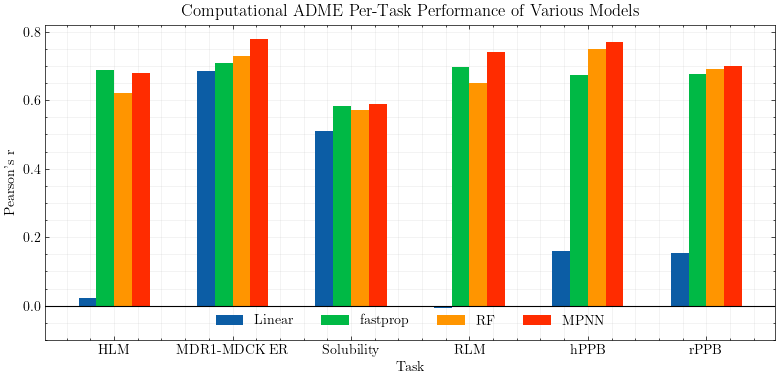

In [9]:
import matplotlib.pyplot as plt
try:
    # this package makes nice plots but is a _pain_ to get working
    # make the import optional
    import scienceplots

    plt.style.use("science")
except:
    pass

data = {
    "Linear": linear_interpolation,
    "fastprop": fastprop_interpolation,
    "RF": [0.62, 0.73, 0.57, 0.65, 0.75, 0.69],
    "MPNN": [0.68, 0.78, 0.59, 0.74, 0.77, 0.70],
}

# chatgpt plot
values = np.array(list(data.values()))
x = np.arange(len(target_names))  # the label locations
width = 0.15  # the width of the bars
fig, ax = plt.subplots(figsize=(8, 4))
for i, model in enumerate(data.keys()):
    ax.bar(x + i * width, values[i], width, label=model)
ax.set_xlabel("Task")
ax.set_ylabel("Pearson's r")
ax.set_ylim(-0.1, 0.82)
ax.grid(which='both', alpha=0.2)
ax.set_axisbelow(True)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_xticks(x + width * (len(data.keys()) - 1) / 2)
ax.set_xticklabels(target_names.keys())
plt.legend(loc="lower center", ncol=len(data))
plt.title("Computational ADME Per-Task Performance of Various Models")
plt.tight_layout()
plt.show()